# LSTM 

In [1]:
import pandas as pd
import numpy as np
import glob
import sys
sys.path.append('../src/')
from evaluation_metrics import *
from utils import *
from lstm_model import *
from matplotlib import pyplot as plt

In [2]:
#load processed data
directory = '../data/processed/'
titles = ['EUR_USD','USD_JPY','AUD_USD','GBP_USD','NZD_USD','USD_CAD','USD_CHF']

file_paths = {}
for title in titles:
    file_paths[title] = glob.glob(directory + f'{title.lower()}_*.npy')
# key to train/test set
xy_data = {}
for key, values in file_paths.items():
    s_val = sorted(values) # X_test, X_train, y_test, y_train
    xy_train_test = {}
    xy_train_test['X_test'] = np.load(s_val[0])
    xy_train_test['X_train'] = np.load(s_val[1])
    xy_train_test['y_test'] = np.load(s_val[2])
    xy_train_test['y_train'] = np.load(s_val[3])
    xy_data[key] = xy_train_test

#validation step
for key, val in xy_data.items():
    print(key)
    for x,y in val.items():
        print(f'{x}: {y.shape}')
    

EUR_USD
X_test: (14919, 30, 8)
X_train: (59673, 30, 8)
y_test: (14919,)
y_train: (59673,)
USD_JPY
X_test: (14919, 30, 8)
X_train: (59672, 30, 8)
y_test: (14919,)
y_train: (59672,)
AUD_USD
X_test: (14918, 30, 8)
X_train: (59668, 30, 8)
y_test: (14918,)
y_train: (59668,)
GBP_USD
X_test: (14919, 30, 8)
X_train: (59673, 30, 8)
y_test: (14919,)
y_train: (59673,)
NZD_USD
X_test: (14922, 30, 8)
X_train: (59684, 30, 8)
y_test: (14922,)
y_train: (59684,)
USD_CAD
X_test: (14917, 30, 8)
X_train: (59668, 30, 8)
y_test: (14917,)
y_train: (59668,)
USD_CHF
X_test: (14917, 30, 8)
X_train: (59668, 30, 8)
y_test: (14917,)
y_train: (59668,)


## Rolling Cross Validation 

### Parameter setup
|Parameters| Value|
|----------|------|
|epochs|50|
|batch size|128|
|early stop patience|5|
|k-fold|5|

In [3]:
histories = {} #model history
cv_models = {} #trained models
log_loss = {} #mean loss 

#create and train lstm model for each pair
for count, (key, xy) in enumerate(xy_data.items()) :
    X_train = xy['X_train']
    y_train = xy['y_train']
    timestep = X_train.shape[1]
    features = X_train.shape[2]

    print(f"Training for {key}")
    model = create_lstm_model(timestep=timestep, features=features)
    history, mean_loss = cross_val(model=model, X=X_train, y=y_train)
    
    histories[key] = history
    cv_models[key] = model
    log_loss[key] = mean_loss
    print(f"Completed training: {count+1}/{len(key)}")
    print("\n")
print("Training complete")

Training for EUR_USD
Split 1, Train sample 11934, Val sample 11934
Epoch 1/50
94/94 [==============================] - 5s 15ms/step - loss: 0.7905 - accuracy: 0.4947 - val_loss: 0.7523 - val_accuracy: 0.4855
Epoch 2/50
94/94 [==============================] - 1s 8ms/step - loss: 0.7698 - accuracy: 0.4964 - val_loss: 0.7325 - val_accuracy: 0.4855
Epoch 3/50
94/94 [==============================] - 1s 8ms/step - loss: 0.7533 - accuracy: 0.4996 - val_loss: 0.7205 - val_accuracy: 0.4855
Epoch 4/50
94/94 [==============================] - 1s 8ms/step - loss: 0.7457 - accuracy: 0.4980 - val_loss: 0.7123 - val_accuracy: 0.4855
Epoch 5/50
94/94 [==============================] - 1s 8ms/step - loss: 0.7381 - accuracy: 0.5088 - val_loss: 0.7072 - val_accuracy: 0.4855
Epoch 6/50
94/94 [==============================] - 1s 8ms/step - loss: 0.7346 - accuracy: 0.5031 - val_loss: 0.7036 - val_accuracy: 0.4855
Epoch 7/50
94/94 [==============================] - 1s 9ms/step - loss: 0.7334 - accuracy: 0

# Cross Validation Evaluation

### Accuracy score over splits
-  A high accuracy with low variance across splits indicates good generalization
-  High variability indicates high dependence on specific training data, likely due to noise

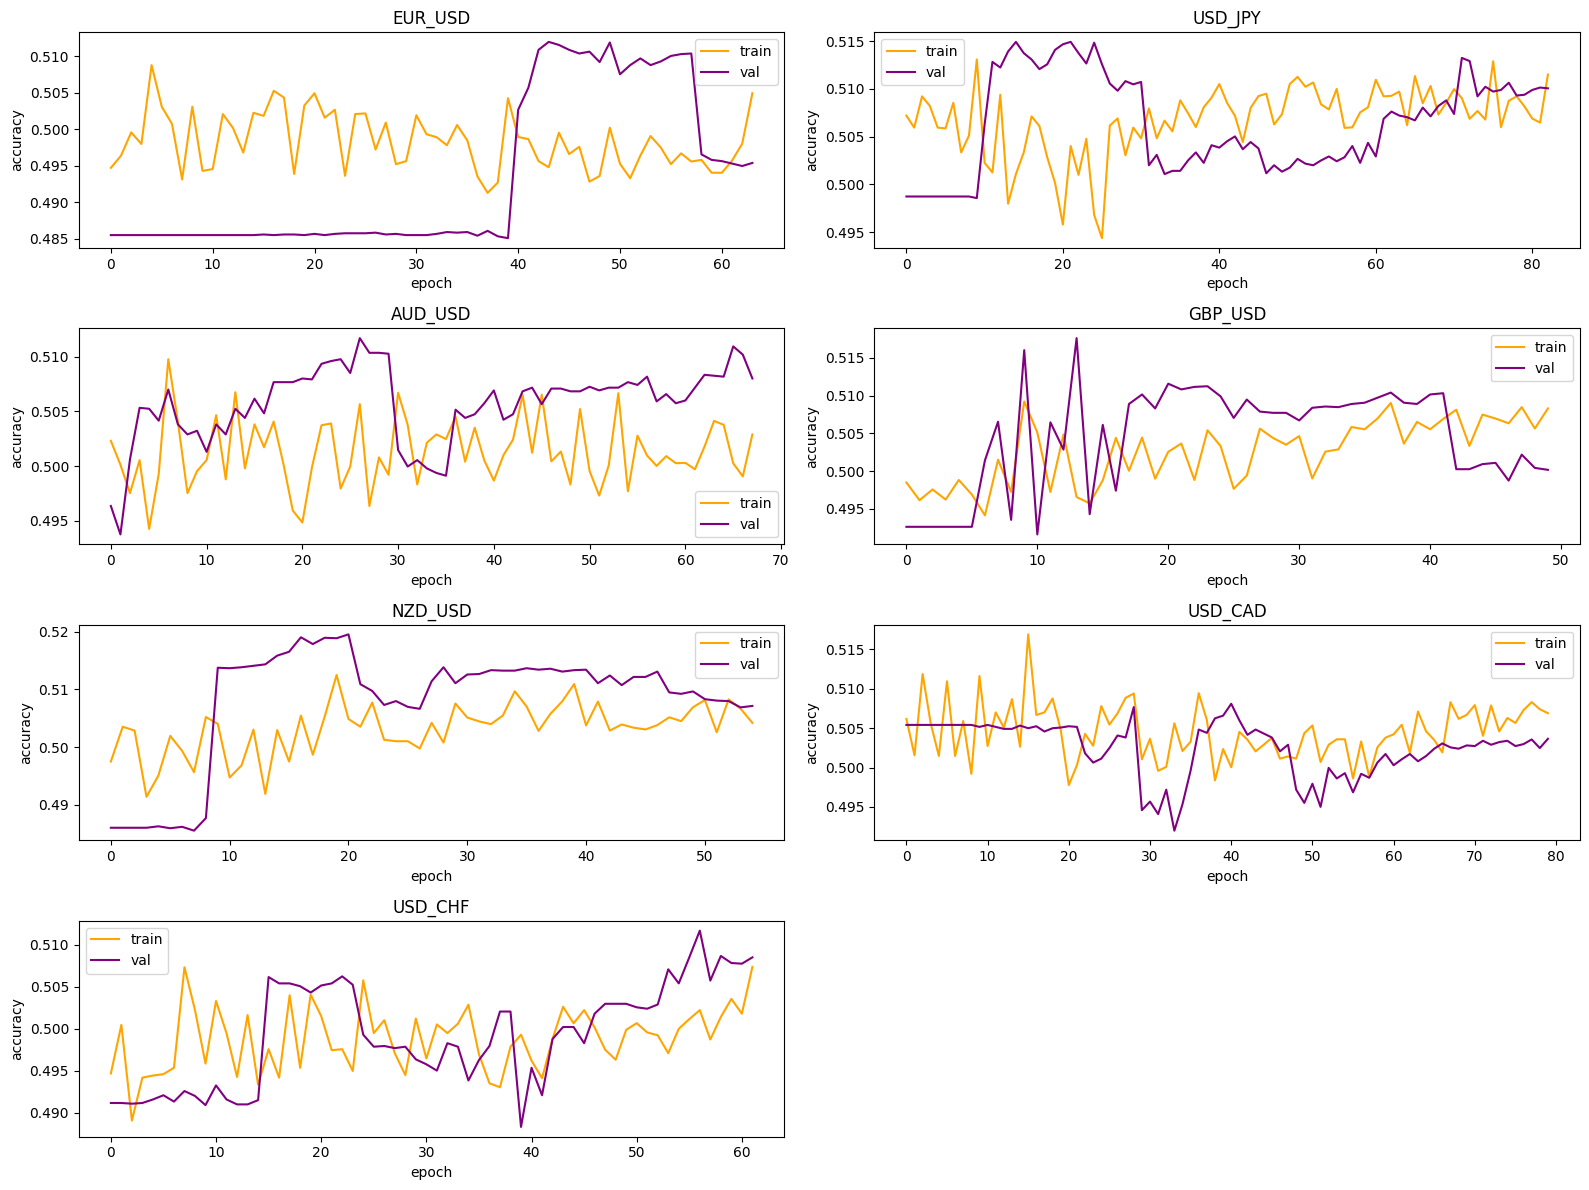

In [4]:
plt.figure(figsize=(16, 12))

for pos, (title, history_list) in enumerate(histories.items()):
    accuracy = []
    val_accuracy = []
    for history in history_list:
        accuracy.extend(history.history['accuracy'])
        val_accuracy.extend(history.history['val_accuracy'])
    plt.subplot(4,2,pos+1)
    plt.plot(accuracy, color='orange',label='train' )
    plt.plot(val_accuracy, color='purple', label='val' )
    plt.title(title)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
plt.tight_layout()
plt.show()
    

### Mean Accuracy

split1 mean train, val: 0.4992157348564693, 0.5029503703117371
split2 mean train, val: 0.5003830790519714, 0.5068890494959695
split3 mean train, val: 0.5021765444959913, 0.5076071449688503
split4 mean train, val: 0.506583937576839, 0.504698531968253


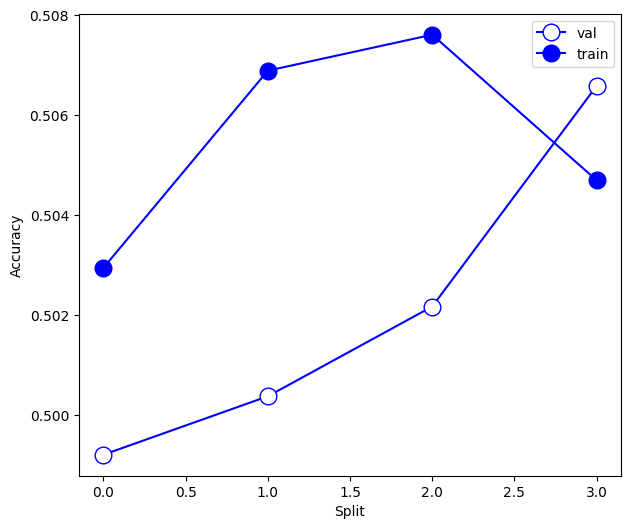

In [5]:
plt.figure(figsize=(7, 6))

splits = []
mean_train_acc = []
mean_val_acc = []



for pos, (title, history_list) in enumerate(histories.items()):
    count = len(history_list)
    for history in history_list:
        splits.append([history.history['accuracy'][-1], history.history['val_accuracy'][-1]])

for i in range(0,count):
    sum_val = 0
    sum_train = 0
    for j in range(i,(count*len(title)),4): #acc,val for each split 1-4
        sum_train = sum_train + splits[j][0]
        sum_val = sum_val + splits[j][1]
    mean_sum_val = sum_val/len(title)
    mean_sum_train = sum_train/len(title)
    print(f'split{i+1} mean train, val: {mean_sum_train}, {mean_sum_val}')
    mean_train_acc.append(mean_sum_train)
    mean_val_acc.append(mean_sum_val)
    
plt.plot(mean_train_acc, label='val', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
plt.plot(mean_val_acc, label='train', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='blue')
plt.xlabel('Split')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Mean Loss
optimized to achieve lowest value

In [6]:
np.mean(np.array(list(log_loss.values())))

0.6930195011083642

split1 mean train, val: 0.7036171300070626, 0.6935059087617057
split2 mean train, val: 0.6967974816049848, 0.6931687338011605
split3 mean train, val: 0.6939105902399335, 0.6930966973304749
split4 mean train, val: 0.6932702319962638, 0.6931159155709403


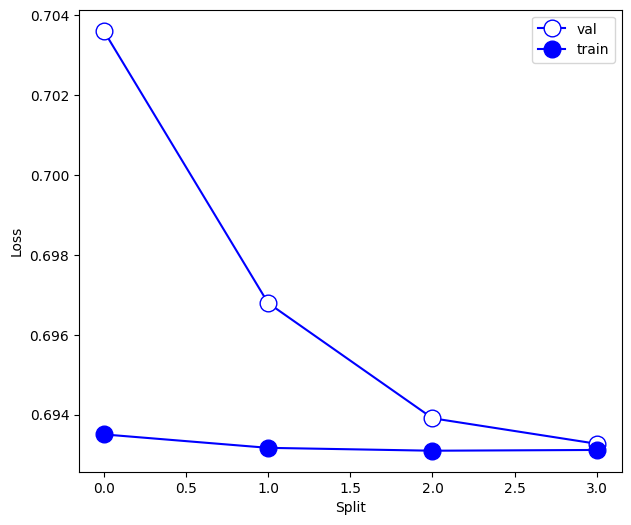

In [7]:
plt.figure(figsize=(7, 6))

splits = []
mean_train_acc = []
mean_val_acc = []



for pos, (title, history_list) in enumerate(histories.items()):
    count = len(history_list)
    for history in history_list:
        splits.append([history.history['loss'][-1], history.history['val_loss'][-1]])

for i in range(0,count):
    sum_val = 0
    sum_train = 0
    for j in range(i,(count*len(title)),4): #acc,val for each split 1-4
        sum_train = sum_train + splits[j][0]
        sum_val = sum_val + splits[j][1]
    mean_sum_val = sum_val/len(title)
    mean_sum_train = sum_train/len(title)
    print(f'split{i+1} mean train, val: {mean_sum_train}, {mean_sum_val}')
    mean_train_acc.append(mean_sum_train)
    mean_val_acc.append(mean_sum_val)
    
plt.plot(mean_train_acc, label='val', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
plt.plot(mean_val_acc, label='train', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='blue')
plt.xlabel('Split')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Loss analysis

Detects for overfitting and underfitting
- Overfitting: Train loss is significantly lower than validation loss
- Underfitting: Train loss and validation loss is both high
- Ideal: Train loss and val loss are equally low 

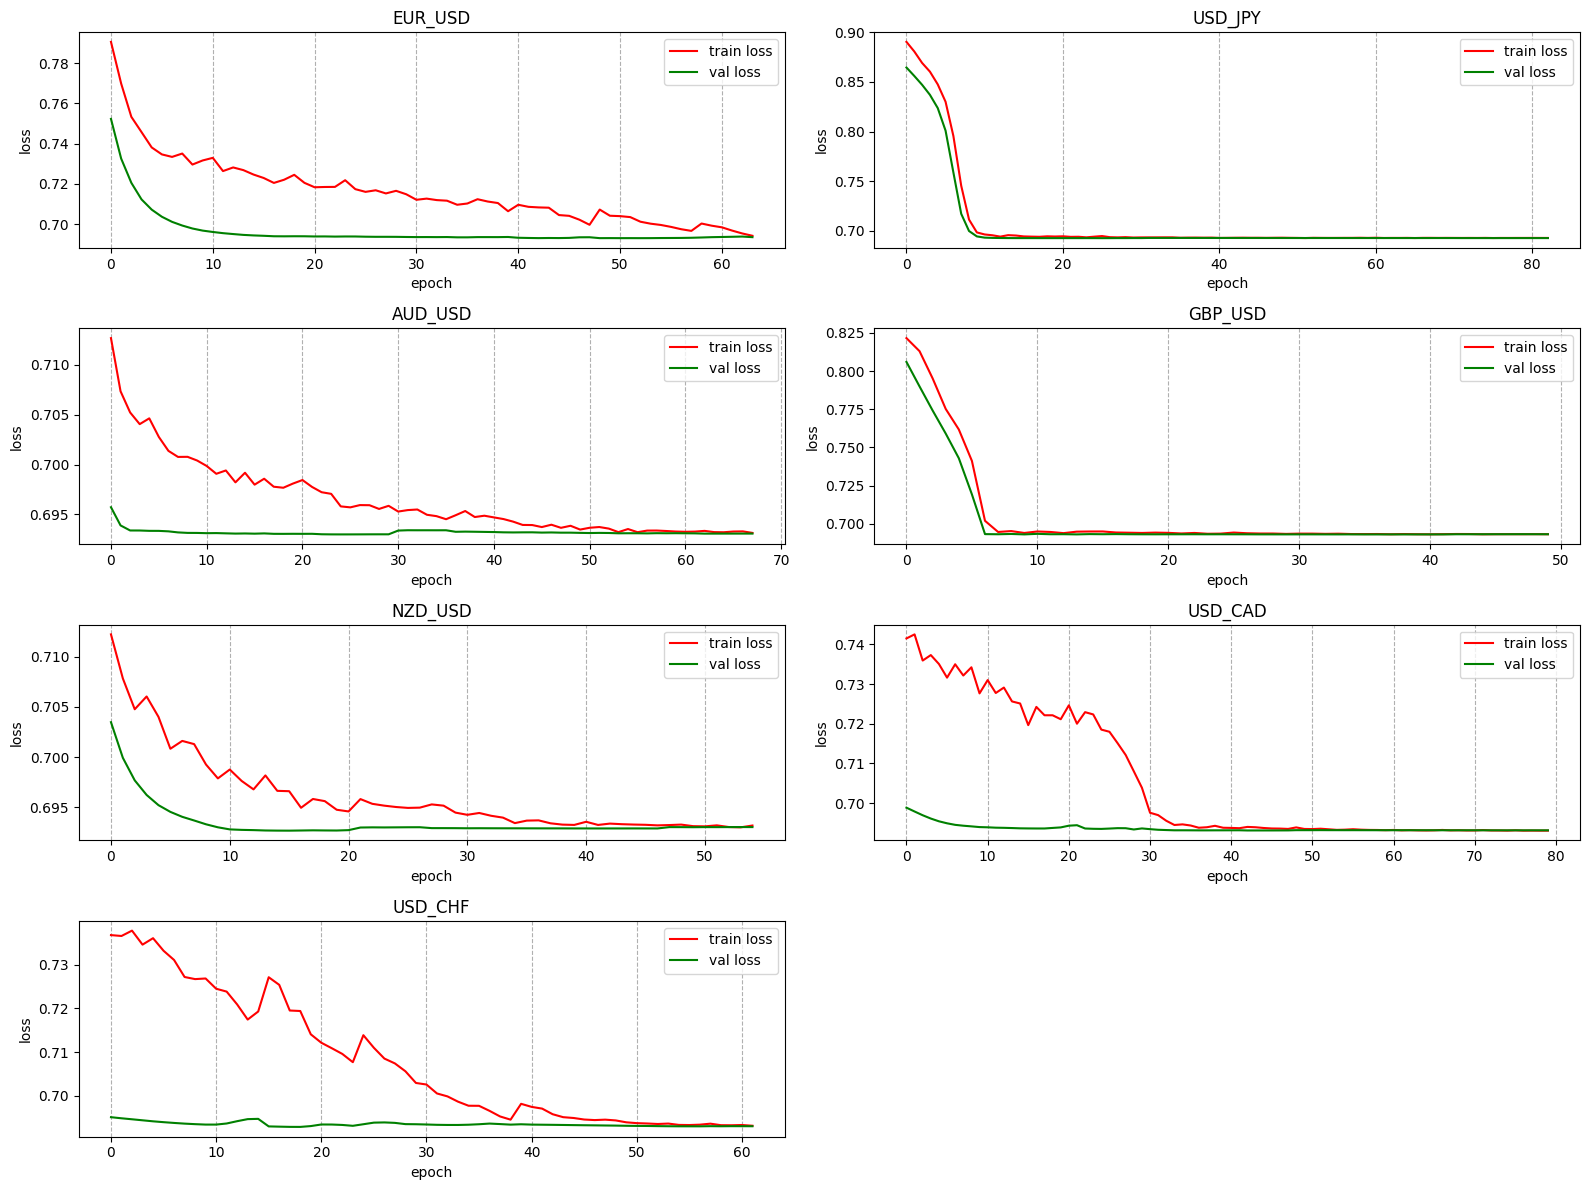

In [8]:
#learning curve 

plt.figure(figsize=(16, 12))

for pos, (title, history_list) in enumerate(histories.items()):
    train_losses = []
    val_losses = []
    for history in history_list:
        train_losses.extend(history.history['loss'])
        val_losses.extend(history.history['val_loss'])
    plt.subplot(4,2,pos+1)
    plt.plot(train_losses, label='train loss', color='red')
    plt.plot(val_losses, label='val loss', color='green')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(axis='x', linestyle='--')
    plt.title(title)
plt.tight_layout()
plt.show()

## Model Summary

In [9]:
cv_models['EUR_USD'].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 544       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


## Train model
- trained on complete X_train, y_train

In [10]:
models = {}
for (key, model), xy in zip(cv_models.items(), xy_data.values()):
    history = train_model(model, xy['X_train'], xy['y_train'])
    models[key] = model

Epoch 1/50
467/467 [==============================] - 3s 6ms/step - loss: 0.6991 - accuracy: 0.4972
Epoch 2/50
467/467 [==============================] - 2s 5ms/step - loss: 0.6973 - accuracy: 0.4980
Epoch 3/50
467/467 [==============================] - 2s 5ms/step - loss: 0.6965 - accuracy: 0.4981
Epoch 4/50
467/467 [==============================] - 3s 6ms/step - loss: 0.6953 - accuracy: 0.5016
Epoch 5/50
467/467 [==============================] - 3s 5ms/step - loss: 0.6951 - accuracy: 0.4972
Epoch 6/50
467/467 [==============================] - 2s 5ms/step - loss: 0.6942 - accuracy: 0.5000
Epoch 7/50
467/467 [==============================] - 2s 5ms/step - loss: 0.6937 - accuracy: 0.5006
Epoch 8/50
467/467 [==============================] - 3s 6ms/step - loss: 0.6934 - accuracy: 0.5036
Epoch 9/50
467/467 [==============================] - 3s 6ms/step - loss: 0.6933 - accuracy: 0.5077
Epoch 10/50
467/467 [==============================] - 3s 6ms/step - loss: 0.6933 - accuracy: 0.5074

## Model Evaluation

### Generate test prediction

In [11]:
threshold = 0.5
y_pred_dict = {}
y_pred_dict_prob = {}
for (key, model), xy in zip(models.items(), xy_data.values() ):
    y_pred = model.predict(xy['X_test'])
    y_pred_dict_prob[key] = y_pred
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_pred_binary = y_pred_binary.flatten() #Convert to 1D
    y_pred_dict[key] = y_pred_binary
    print(key)
    print(np.bincount(y_train))  # Count occurrences of each class in the training set
    print(np.bincount(xy['y_test']))   # testing set
    print(np.bincount(y_pred_binary)) # prediction set
    print(len(xy['y_test'])-len(y_pred_binary))
    print(len)

467/467 [==============================] - 1s 2ms/step
EUR_USD
[30040 29628]
[7506 7413]
[12337  2582]
0
<built-in function len>
467/467 [==============================] - 1s 2ms/step
USD_JPY
[30040 29628]
[7340 7579]
[  194 14725]
0
<built-in function len>
467/467 [==============================] - 1s 2ms/step
AUD_USD
[30040 29628]
[7516 7402]
[10847  4071]
0
<built-in function len>
467/467 [==============================] - 1s 2ms/step
GBP_USD
[30040 29628]
[7471 7448]
[12086  2833]
0
<built-in function len>
467/467 [==============================] - 1s 2ms/step
NZD_USD
[30040 29628]
[7628 7294]
[13686  1236]
0
<built-in function len>
467/467 [==============================] - 1s 2ms/step
USD_CAD
[30040 29628]
[7560 7357]
[14347   570]
0
<built-in function len>
467/467 [==============================] - 1s 2ms/step
USD_CHF
[30040 29628]
[7507 7410]
[13141  1776]
0
<built-in function len>


#### Visualization of y_test and y_pred

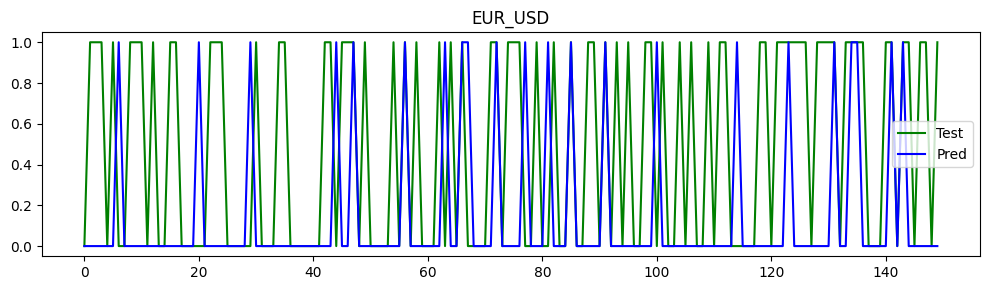

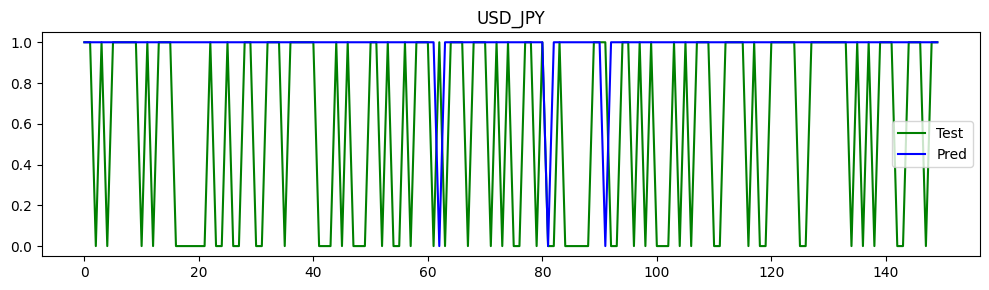

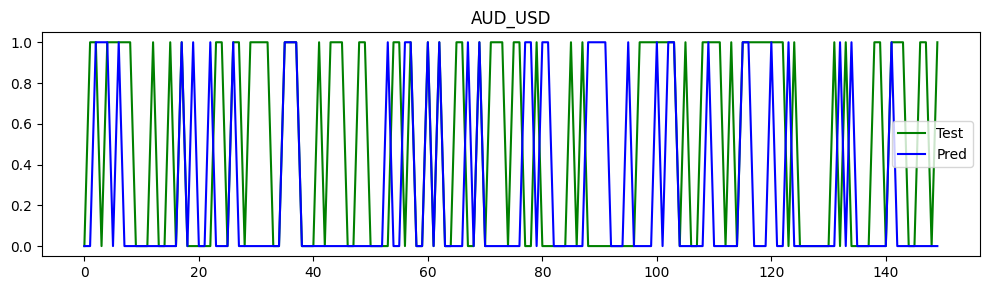

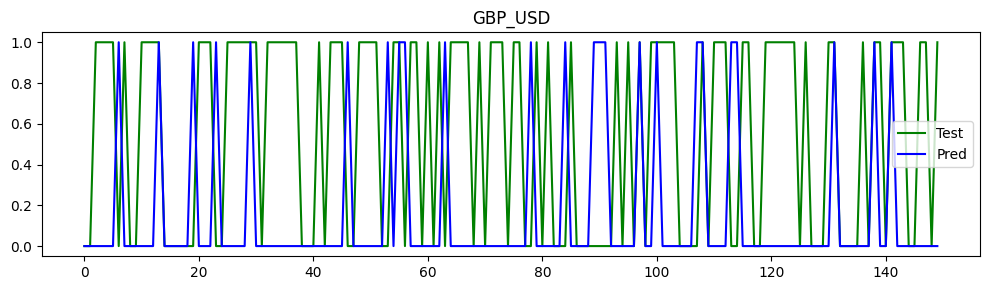

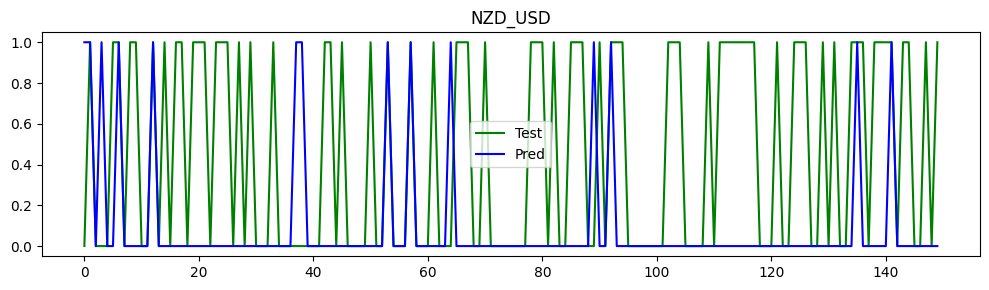

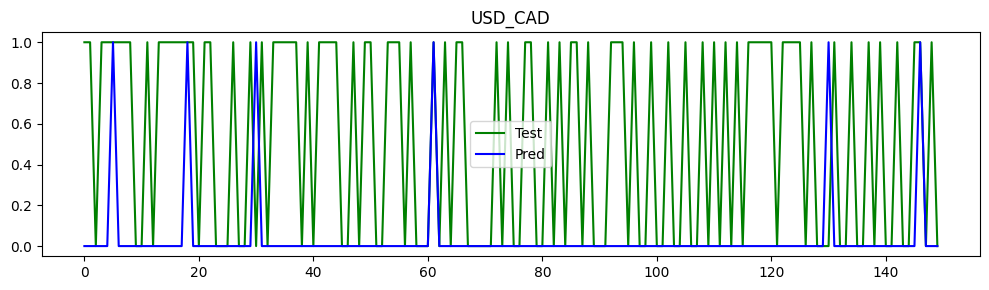

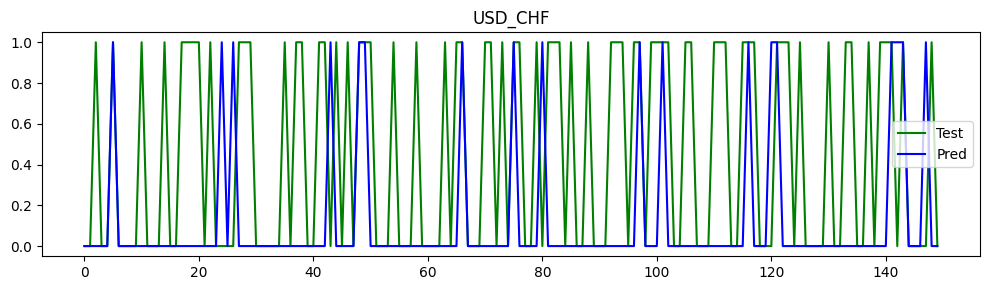

In [12]:
for pos, ((key, y_pred), xy) in enumerate(zip(y_pred_dict.items(),xy_data.values())):  
    step = 100 
    y_test_ds = xy['y_test'][::step] #downsampled to 100 steps
    y_pred_ds = y_pred[::step]
    
    #plt.subplot(7,1,pos+1)
    plt.figure(figsize=(10,3))
    plt.plot(y_test_ds, color = "green", label = "Test")
    plt.plot(y_pred_ds, color = "blue", label = "Pred")
    plt.title(key)
    plt.tight_layout()
    plt.legend()

plt.show()

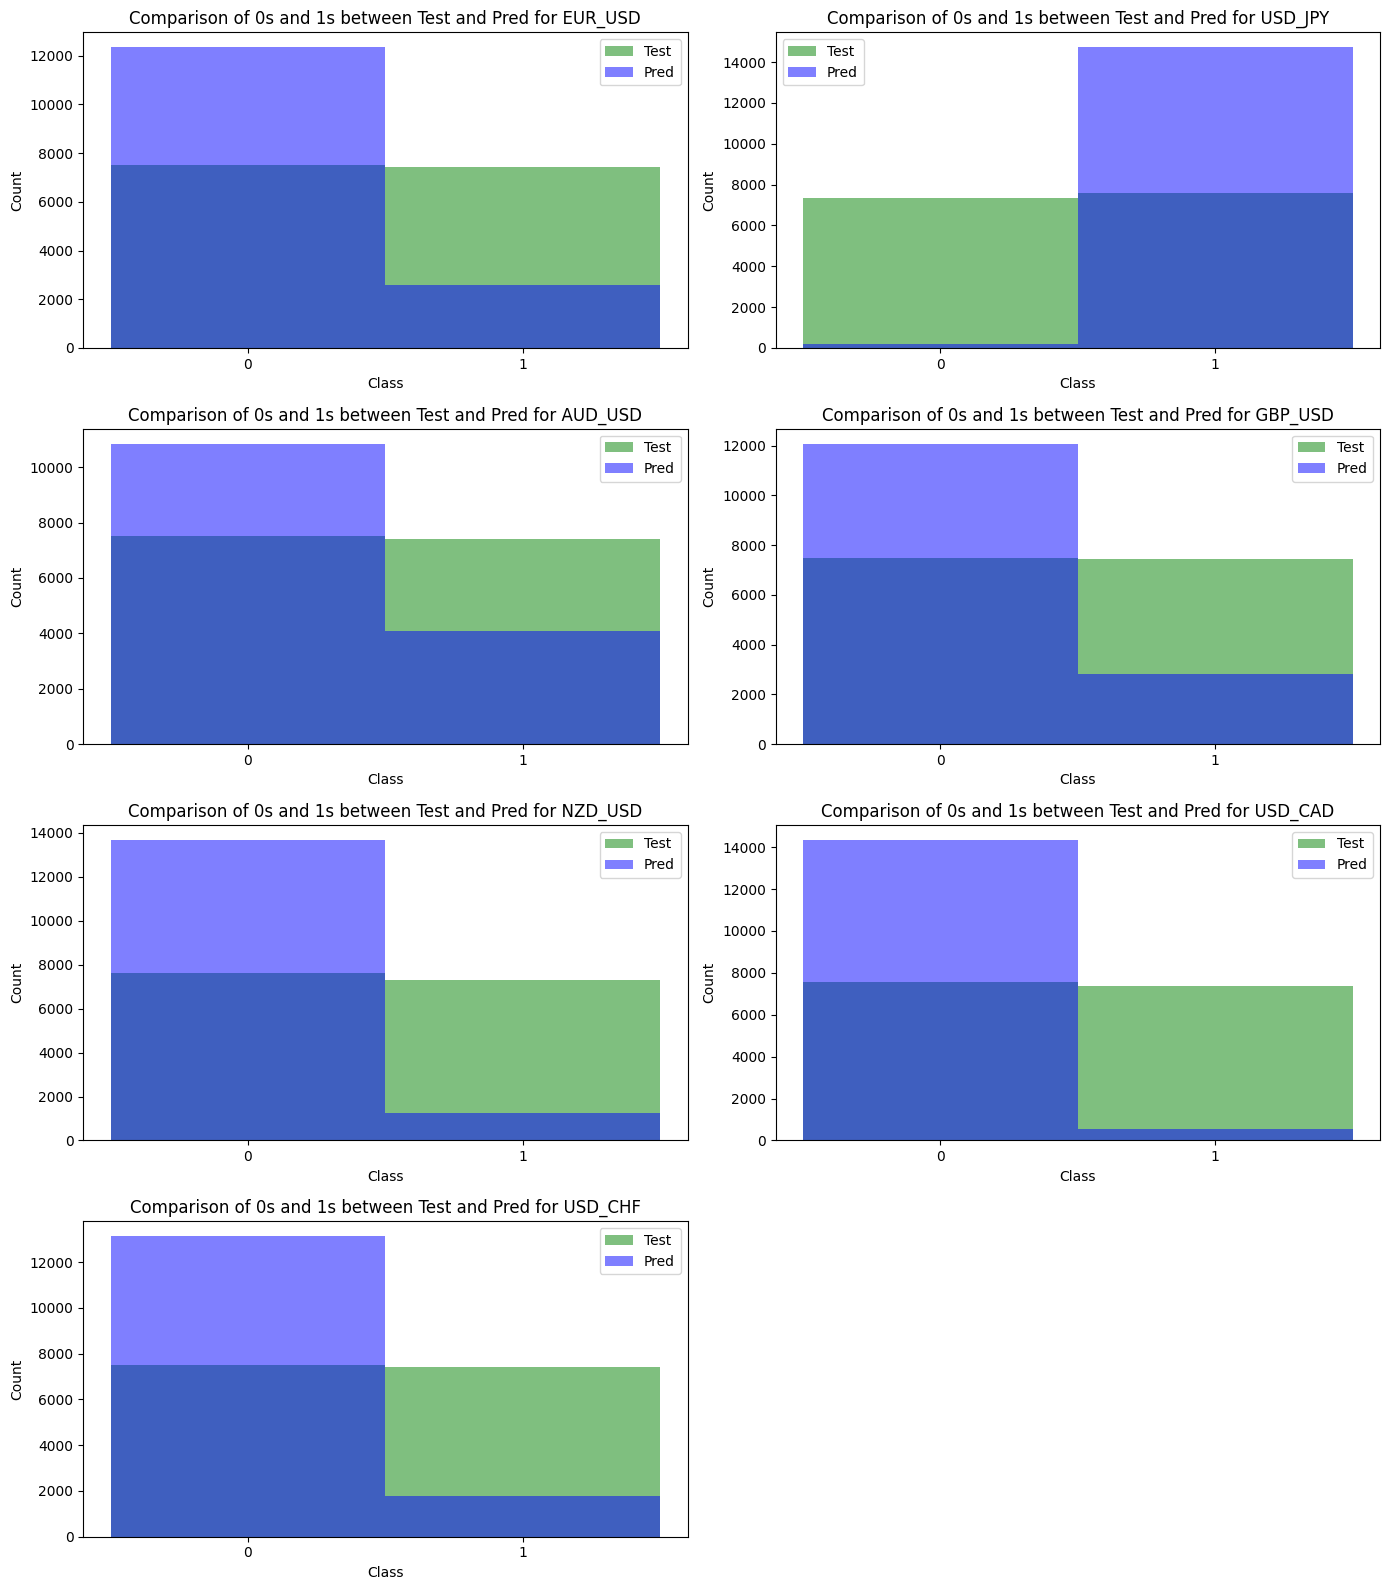

In [13]:
plt.figure(figsize=(14, 16))

for pos, ((key, y_pred), xy) in enumerate (zip(y_pred_dict.items(), xy_data.values())):
    test_counts = np.bincount(xy['y_test'])
    pred_counts = np.bincount(y_pred)

    # Plotting histograms using plt directly
    plt.subplot(4,2,pos+1)
    # Plot test data histogram
    plt.hist(xy['y_test'], bins=[-0.5, 0.5, 1.5], alpha=0.5, color='green', label='Test')

    # Plot pred data histogram
    plt.hist(y_pred, bins=[-0.5, 0.5, 1.5], alpha=0.5, color='blue', label='Pred')

    # Customize plot
    plt.xticks([0, 1], ['0', '1'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Comparison of 0s and 1s between Test and Pred for {key}')
    plt.tight_layout()
    plt.legend()
    

plt.show()

## Metrics

Evaluate performance with accuracy, f1_score, precision and recall

In [14]:
metrics_dict = {}

for xy, (key, y_pred) in zip(xy_data.values(), y_pred_dict.items()):
    
    metrics = calculate_metrics(xy['y_test'], y_pred)
    metrics_dict[key] = metrics
    print(f"{key}: ", metrics)
    print(len(xy['y_test'])-len(y_pred))

EUR_USD:  {'accuracy': 0.5135732957973055, 'f1_score': 0.2739369684842421, 'precision': 0.5302091402013943, 'recall': 0.18467556994469175}
0
USD_JPY:  {'accuracy': 0.5076077485086132, 'f1_score': 0.670642037302726, 'precision': 0.507911714770798, 'recall': 0.9868056471830057}
0
AUD_USD:  {'accuracy': 0.5116637618983778, 'f1_score': 0.36503094221215027, 'precision': 0.5143699336772292, 'recall': 0.28289651445555253}
0
GBP_USD:  {'accuracy': 0.5064682619478518, 'f1_score': 0.28382453068767627, 'precision': 0.5150017649135192, 'recall': 0.19589151450053705}
0
NZD_USD:  {'accuracy': 0.5158825894652191, 'f1_score': 0.15310668229777258, 'precision': 0.5283171521035599, 'recall': 0.08952563751028242}
0
USD_CAD:  {'accuracy': 0.5064020915733727, 'f1_score': 0.07114923678566923, 'precision': 0.49473684210526314, 'recall': 0.03833084137556069}
0
USD_CHF:  {'accuracy': 0.5099550848025742, 'f1_score': 0.204223818854779, 'precision': 0.5281531531531531, 'recall': 0.12658569500674763}
0


#### Metric Bar Chart

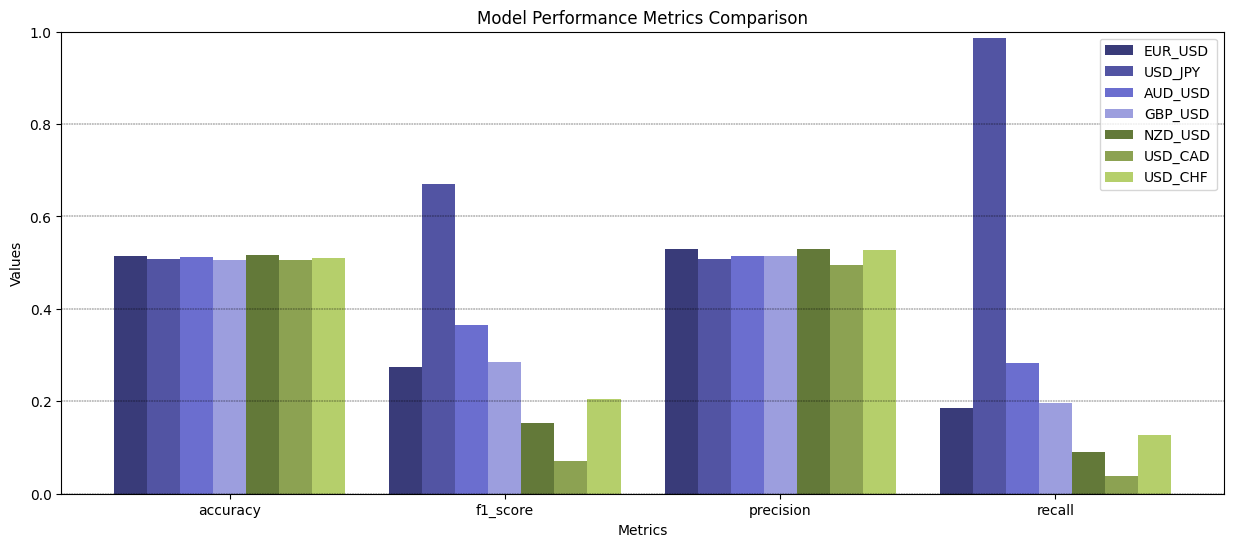

In [15]:
all_metrics = list(next(iter(metrics_dict.values())).keys())

num_models = len(metrics_dict)
bar_width = 0.12
index = np.arange(len(all_metrics))

plt.figure(figsize=(15, 6))
colors = plt.get_cmap('tab20b').colors

for i, (key, metrics) in enumerate(metrics_dict.items()):
    values = [metrics[metric] for metric in all_metrics]
    plt.bar(index + i * bar_width, values, bar_width, label=key, color=colors[i])
    
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Metrics Comparison')
plt.xticks(index + bar_width * (num_models - 1) / 2, all_metrics)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', linewidth=0.35, color='black')

plt.show()

#### Reciever Operating Characteristic Curve

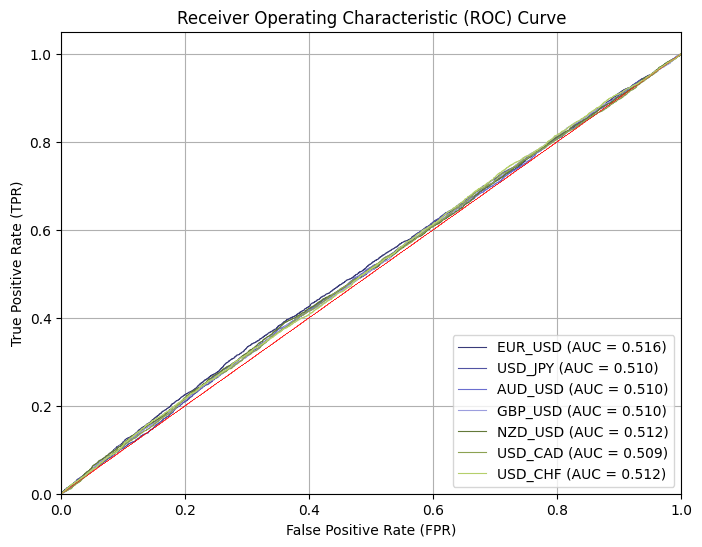

In [16]:
from sklearn.metrics import roc_curve, auc
y_probs = xy_data.items()
y_pred_dict_prob

plt.figure(figsize=(8, 6))
for i, ((key, xy), y_prob) in enumerate(zip(xy_data.items(), y_pred_dict_prob.values())):
    fpr, tpr, thresholds = roc_curve(xy['y_test'], y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=0.8, label=f'{key} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
plt.show()

#### Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix

for (title, y_pred), xy in zip(y_pred_dict.items(), xy_data.values()):
    print(title)
    cm = confusion_matrix(xy['y_test'], y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')
    

EUR_USD
True Negatives: 6293, False Positives: 1213, False Negatives: 6044, True Positives: 1369
USD_JPY
True Negatives: 94, False Positives: 7246, False Negatives: 100, True Positives: 7479
AUD_USD
True Negatives: 5539, False Positives: 1977, False Negatives: 5308, True Positives: 2094
GBP_USD
True Negatives: 6097, False Positives: 1374, False Negatives: 5989, True Positives: 1459
NZD_USD
True Negatives: 7045, False Positives: 583, False Negatives: 6641, True Positives: 653
USD_CAD
True Negatives: 7272, False Positives: 288, False Negatives: 7075, True Positives: 282
USD_CHF
True Negatives: 6669, False Positives: 838, False Negatives: 6472, True Positives: 938


## Save results


In [19]:
#Save results to csv
model_type = 'LSTM'

for key, metrics in metrics_dict.items():
    metrics_df = pd.DataFrame([metrics])
    save_metrics_to_csv(metrics_df, model_type, f'{key}')

End of section